In [1]:
% run 1-datasource.ipynb

In [2]:
% run 4-graph-utils.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
import scipy.sparse.csgraph
from tensorboardX import SummaryWriter
import skimage.transform as transform
import networkx as nx
from scipy import spatial

In [4]:
#from pygsp.reduction import graph_sparsify#, kron_reduction
from pygsp import graphs, filters, utils
from scipy.sparse.linalg import eigsh
from scipy.sparse import linalg
from scipy import sparse, stats

In [5]:
icebergs.head()

,band_1,band_2,inc_angle,is_iceberg
id,,,,
dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


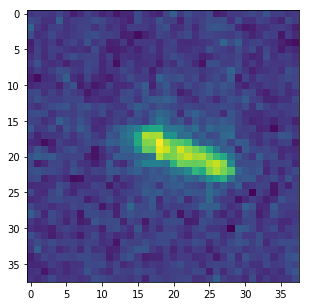

In [6]:
test = transform.rescale(icebergs.band_1.iloc[100].reshape(75, 75), 0.5, mode='constant')
plt.imshow(test);

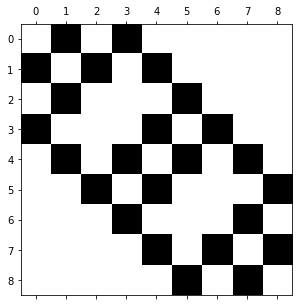

In [7]:
plt.spy(distance(grid(3), k=1, metric='cityblock'));

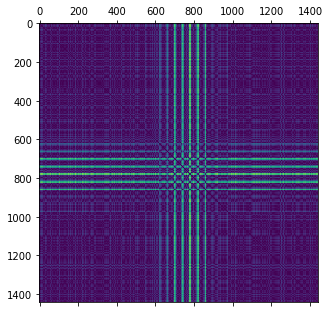

In [8]:
test_dist = spatial.distance.squareform(spatial.distance.pdist(test.reshape(-1, 1), metric='euclidean'))
plt.matshow(test_dist);

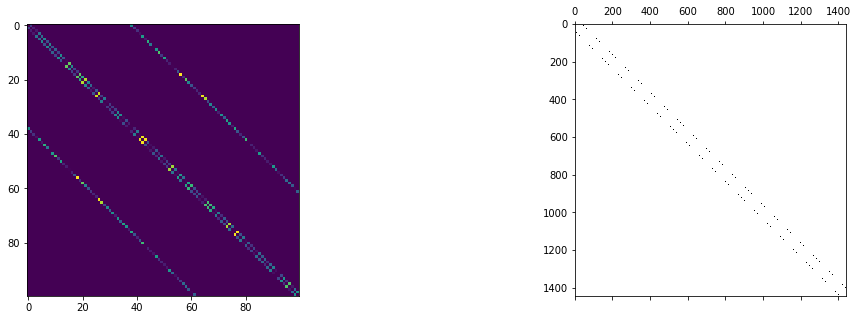

In [9]:
test_dist[np.where(distance(grid(38), k=2) == 0)] = 0

plt.subplot(121)
plt.imshow(test_dist[:100, :100])

plt.subplot(122)
plt.spy(test_dist);

In [10]:
def graph_sparsify(M, epsilon, maxiter=10):
    r"""Sparsify a graph (with Spielman-Srivastava).

    Parameters
    ----------
    M : Graph or sparse matrix
        Graph structure or a Laplacian matrix
    epsilon : int
        Sparsification parameter

    Returns
    -------
    Mnew : Graph or sparse matrix
        New graph structure or sparse matrix

    Notes
    -----
    Epsilon should be between 1/sqrt(N) and 1

    Examples
    --------
    >>> from pygsp import reduction
    >>> G = graphs.Sensor(256, Nc=20, distribute=True)
    >>> epsilon = 0.4
    >>> G2 = reduction.graph_sparsify(G, epsilon)

    References
    ----------
    See :cite:`spielman2011graph`, :cite:`rudelson1999random` and :cite:`rudelson2007sampling`.
    for more informations

    """
    # Test the input parameters
    if isinstance(M, graphs.Graph):
        """if not M.lap_type == 'combinatorial':
            raise NotImplementedError"""
        L = M.L
    else:
        L = M

    N = np.shape(L)[0]

    if not 1./np.sqrt(N) <= epsilon < 1:
        raise ValueError('GRAPH_SPARSIFY: Epsilon out of required range')

    # Not sparse
    resistance_distances = resistance_distance(L).toarray()
    # Get the Weight matrix
    if isinstance(M, graphs.Graph):
        W = M.W
    else:
        W = np.diag(L.diagonal()) - L.toarray()
        W[W < 1e-10] = 0

    W = sparse.coo_matrix(W)
    W.data[W.data < 1e-10] = 0
    W = W.tocsc()
    W.eliminate_zeros()

    start_nodes, end_nodes, weights = sparse.find(sparse.tril(W))

    # Calculate the new weights.
    weights = np.maximum(0, weights)
    Re = np.maximum(0, resistance_distances[start_nodes, end_nodes])
    Pe = weights * Re
    Pe = Pe / np.sum(Pe)

    for i in range(maxiter):
        # Rudelson, 1996 Random Vectors in the Isotropic Position
        # (too hard to figure out actual C0)
        C0 = 1 / 30.
        # Rudelson and Vershynin, 2007, Thm. 3.1
        C = 4 * C0
        q = round(N * np.log(N) * 9 * C**2 / (epsilon**2))

        results = stats.rv_discrete(values=(np.arange(np.shape(Pe)[0]), Pe)).rvs(size=int(q))
        spin_counts = stats.itemfreq(results).astype(int)
        per_spin_weights = weights / (q * Pe)

        counts = np.zeros(np.shape(weights)[0])
        counts[spin_counts[:, 0]] = spin_counts[:, 1]
        new_weights = counts * per_spin_weights

        sparserW = sparse.csc_matrix((new_weights, (start_nodes, end_nodes)),
                                     shape=(N, N))
        sparserW = sparserW + sparserW.T
        sparserL = sparse.diags(sparserW.diagonal(), 0) - sparserW

        if graphs.Graph(W=sparserW).is_connected():
            break
        elif i == maxiter - 1:
            logger.warning('Despite attempts to reduce epsilon, sparsified graph is disconnected')
        else:
            epsilon -= (epsilon - 1/np.sqrt(N)) / 2.

    if isinstance(M, graphs.Graph):
        sparserW = sparse.diags(sparserL.diagonal(), 0) - sparserL
        if not M.is_directed():
            sparserW = (sparserW + sparserW.T) / 2.

        Mnew = graphs.Graph(W=sparserW)
        #M.copy_graph_attributes(Mnew)
    else:
        Mnew = sparse.lil_matrix(sparserL)

    return Mnew

def resistance_distance(G):
    r"""
    Compute the resistance distances of a graph.

    Parameters
    ----------
    G : Graph or sparse matrix
        Graph structure or Laplacian matrix (L)

    Returns
    -------
    rd : sparse matrix
        distance matrix

    References
    ----------
    :cite:`klein1993resistance`
    """

    if sparse.issparse(G):
        L = G.tocsc()

    else:
        """if G.lap_type != 'combinatorial':
            raise ValueError('Need a combinatorial Laplacian.')"""
        L = G.L.tocsc()

    pseudo = sparse.lil_matrix(np.linalg.pinv(L.toarray()))

    N = np.shape(L)[0]
    d = sparse.csc_matrix(pseudo.diagonal())
    rd = sparse.kron(d, sparse.csc_matrix(np.ones((N, 1)))).T \
        + sparse.kron(d, sparse.csc_matrix(np.ones((N, 1)))) \
        - pseudo - pseudo.T

    return rd

def kron_reduction(G, ind):
    if isinstance(G, graphs.Graph):
        L = G.L
    else:
        L = G
    
    L.eliminate_zeros()

    N = np.shape(L)[0]
    ind_comp = np.setdiff1d(np.arange(N, dtype=int), ind)

    L_red = L[np.ix_(ind, ind)]
    L_in_out = L[np.ix_(ind, ind_comp)]
    L_out_in = L[np.ix_(ind_comp, ind)].tocsc()
    L_comp = L[np.ix_(ind_comp, ind_comp)].tocsc()
    
    

    Lnew = L_red - L_in_out.dot(linalg.spsolve(L_comp, L_out_in))
    
    #Lnew = Lnew +  sp.sparse.eye(Lnew.shape[0])

    # Make the laplacian symmetric if it is almost symmetric!
    if np.abs(Lnew - Lnew.T).sum() < np.spacing(1) * np.abs(Lnew).sum():
        Lnew = (Lnew + Lnew.T) / 2.

    if isinstance(G, graphs.Graph):
        # Suppress the diagonal ? This is a good question?
        Wnew = sp.sparse.diags(Lnew.diagonal(), 0) - Lnew
        Snew = Lnew.diagonal() - np.ravel(Wnew.sum(0))
        if np.linalg.norm(Snew, 2) >= np.spacing(1000):
            Wnew = Wnew + sp.sparse.diags(Snew, 0)

        # Removing diagonal for stability
        

        coords = G.coords[ind, :] if len(G.coords.shape) else np.ndarray(None)
        
        
        Wnew = Wnew - Wnew.diagonal()
        
        #Wnew = (Wnew + Wnew.T)/2.0
        
        Gnew = graphs.Graph(W=Wnew, coords=coords, lap_type='combinatorial',
                            plotting=G.plotting, gtype='Kron reduction')
    else:
        Gnew = Lnew

    return Gnew

def graph_multiresolution(G, levels=3, sparsify=True, reg_eps=0.005, sparsify_eps = None):
    if sparsify_eps == None:
        sparsify_eps = min(10. / np.sqrt(G.N), 0.3)
    #G.estimate_lmax()

    Gs = [G]
    Gs[0].mr = {'idx': np.arange(G.N), 'orig_idx': np.arange(G.N)}

    for i in range(levels):

        if hasattr(Gs[i], '_U'):
            V = Gs[i].U[:, -1]
        else:
            V = np.linalg.eigh(Gs[i].L.todense())[1][:, -1]

        V *= np.sign(V[0])
        ind = np.nonzero(V >= 0)[0]
        N = V.shape[0]

        #U1, V1 = linalg.eigsh(Gs[i].L, k=3, which='SM')
        #coords = list(zip(V1[:, 1], V1[:, 2]))
        Gs[i].set_coordinates()
        Gs.append(kron_reduction(Gs[i], ind))
        #Gs[i].L = rw_laplacian(Gs[i].W)

        if sparsify and Gs[i+1].N > 2:
            Gs[i+1] = graph_sparsify(Gs[i+1], min(max(sparsify_eps, 2. / np.sqrt(Gs[i+1].N)), 1.))

        #Gs[i+1].estimate_lmax()

        Gs[i+1].mr = {'idx': ind, 'orig_idx': Gs[i].mr['orig_idx'][ind], 'level': i}

        L_reg = Gs[i].L + reg_eps * sp.sparse.eye(Gs[i].N)
        Gs[i].mr['K_reg'] = kron_reduction(L_reg, ind)
        Gs[i].mr['green_kernel'] = filters.Filter(Gs[i], lambda x: 1./(reg_eps + x))
        Gs[i].compute_fourier_basis()
    return Gs

In [11]:
G = graphs.Graph(test_dist)
#G.L = rw_laplacian(G.W)
#U, V = np.linalg.eigh(G.L.todense())
#V = sp.sparse.linalg.eigs(G.L, 1, which='LM')[1][:, 0]
#print(V[:,-1])
G.set_coordinates()

In [12]:
Gs = graph_multiresolution(G)

AttributeError: Graph has no coordinate set. Please run G.set_coordinates() first.

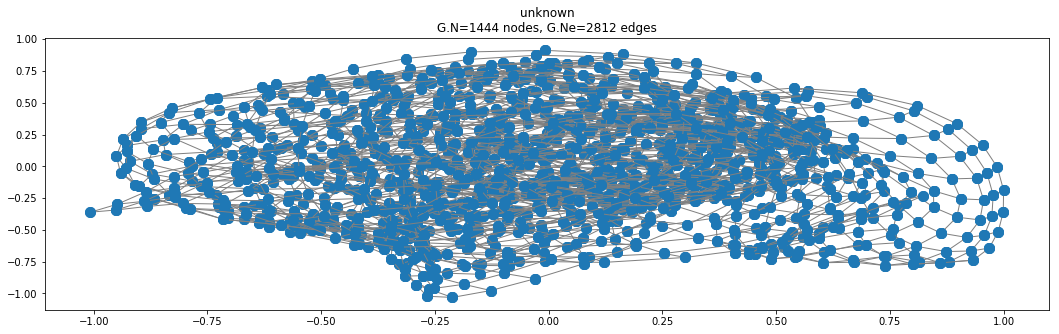

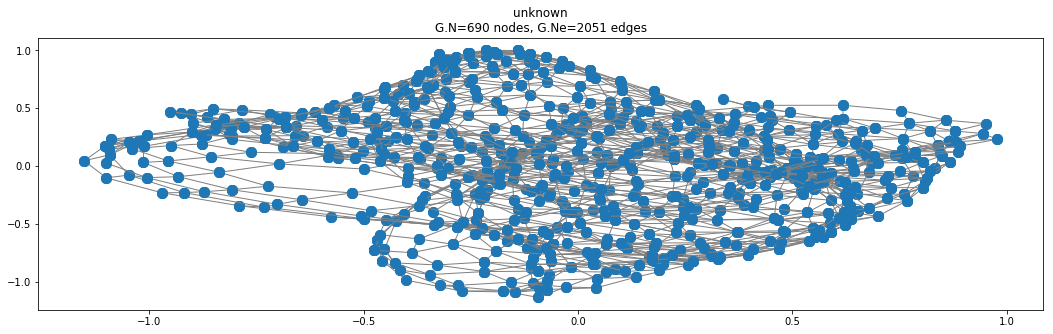

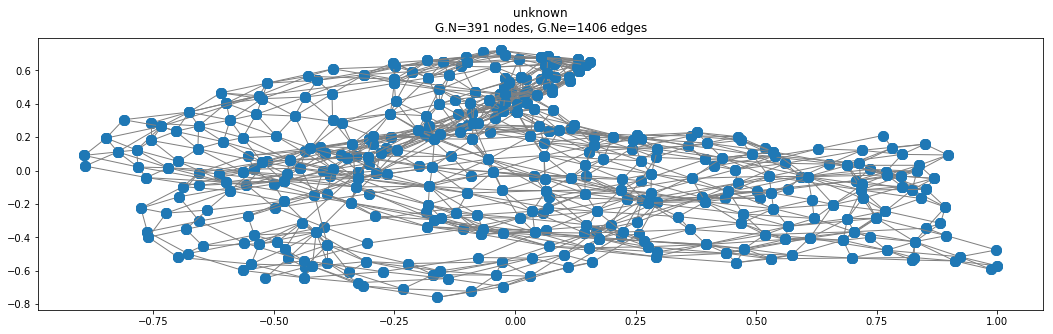

In [13]:
for g in Gs:

    g.plot()

690, 2010

370, 1379

AttributeError: Graph has no coordinate set. Please run G.set_coordinates() first.

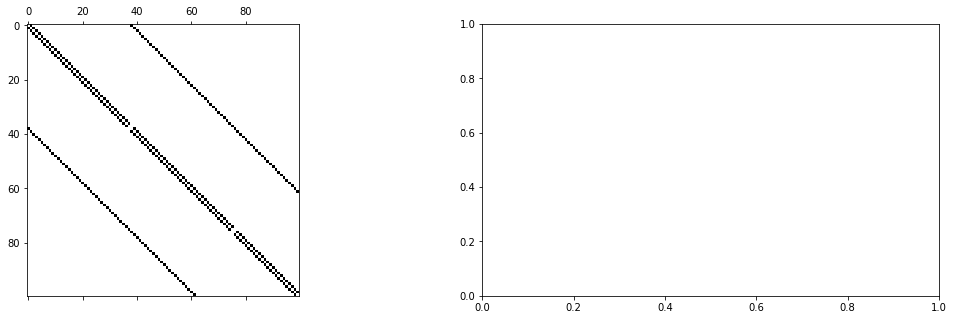

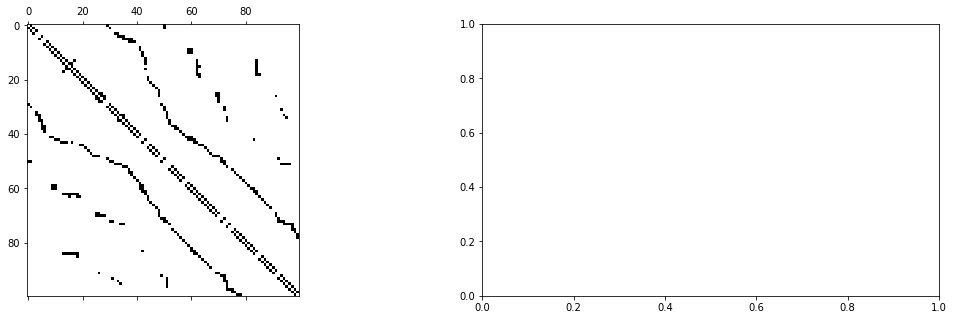

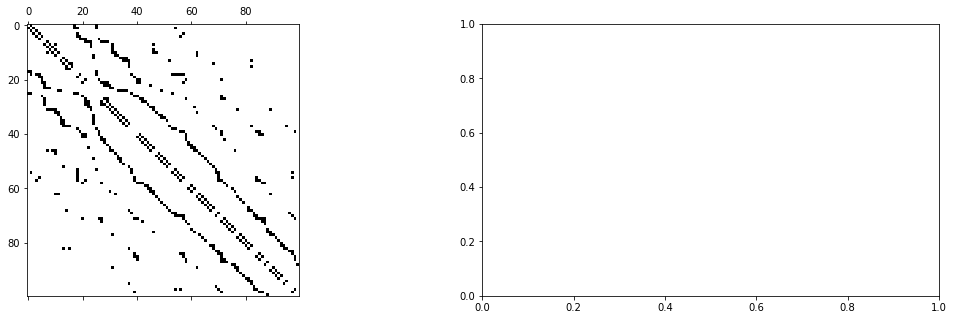

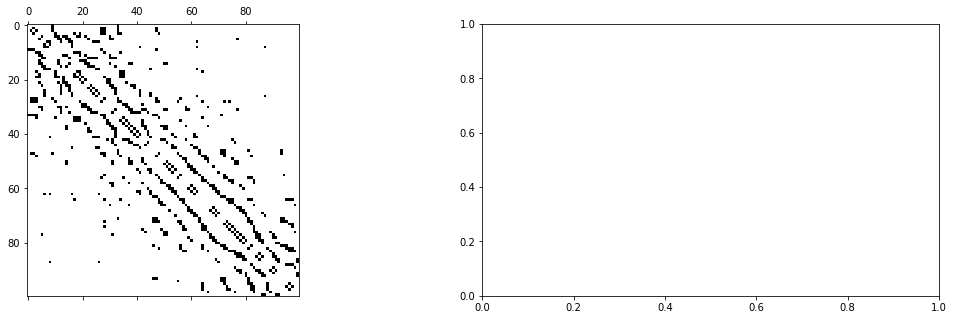

In [14]:
for g in Gs:
    plt.subplot(121)
    plt.spy(g.W.todense()[:100,:100])
    plt.subplot(122)
    g.plot()

In [ ]:
Gs[2].W.todense()

In [ ]:
Gs[2].W

In [ ]:
plt.spy(Gs[2].W.todense());

In [ ]:
G = sp.sparse.csr.csr_matrix(distance(grid(4), 1, metric='cityblock'))

In [ ]:
plt.spy(G.todense())

In [ ]:
graphs, perm = coarsen(G, levels=2, self_connections=False)

In [ ]:
perm

In [ ]:
for g in graphs:
    plt.subplot(121)
    plt.spy(g.todense())
    plt.subplot(122)
    nx.draw(nx.from_numpy_array(g.todense()))
    plt.show()

In [ ]:
gr = grid(38)
gr.shape

In [ ]:
mask = distance(gr, k=3) > 0
plt.spy(mask[:40, :40]);

In [ ]:
graphs, perm = coarsen(sp.sparse.csr.csr_matrix(mask), levels=3, self_connections=False)